#### Import libraries  

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from joblib import dump

#### Parameters  

In [33]:
csv_in = 'winequality-white_small.csv'

#### Read CSV file  

In [34]:
df = pd.read_csv(csv_in, delimiter=',', skiprows=0, header=0)
print(df.shape)
print(df.info())
display(df.head())

(1223, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1223 entries, 0 to 1222
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1223 non-null   float64
 1   volatile_acidity      1223 non-null   float64
 2   citric_acid           1223 non-null   float64
 3   residual_sugar        1223 non-null   float64
 4   chlorides             1223 non-null   float64
 5   free_sulfur_dioxide   1223 non-null   float64
 6   total_sulfur_dioxide  1223 non-null   float64
 7   density               1223 non-null   float64
 8   pH                    1223 non-null   float64
 9   sulphates             1223 non-null   float64
 10  alcohol               1223 non-null   float64
 11  quality               1223 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 114.8 KB
None


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,6.2,0.32,0.16,7.00,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6
1,8.1,0.27,0.41,1.45,0.033,11.0,63.0,0.9908,2.99,0.56,12.0,5
2,7.9,0.18,0.37,1.20,0.040,16.0,75.0,0.9920,3.18,0.63,10.8,5
3,6.6,0.17,0.38,1.50,0.032,28.0,112.0,0.9914,3.25,0.55,11.4,7
4,6.2,0.66,0.48,1.20,0.029,29.0,75.0,0.9892,3.33,0.39,12.8,8


#### Get X and y  

In [35]:
X = df.iloc[:, :-1]  # explanatory variables
y = df['quality']  # objective variable
print('X:', X.shape)
display(X.head())
print('y:', y.shape)
print(y.head())

X: (1223, 11)


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,6.2,0.32,0.16,7.00,0.045,30.0,136.0,0.9949,3.18,0.47,9.6
1,8.1,0.27,0.41,1.45,0.033,11.0,63.0,0.9908,2.99,0.56,12.0
2,7.9,0.18,0.37,1.20,0.040,16.0,75.0,0.9920,3.18,0.63,10.8
3,6.6,0.17,0.38,1.50,0.032,28.0,112.0,0.9914,3.25,0.55,11.4
4,6.2,0.66,0.48,1.20,0.029,29.0,75.0,0.9892,3.33,0.39,12.8


y: (1223,)
0    6
1    5
2    5
3    7
4    8
Name: quality, dtype: int64


#### Make pipeline and set parameters for grid search   

In [36]:
abc=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=3)      

# Hyperparameter settings for grid search
param_grid = {
    'n_estimators': [10, 50, 100],
    'learning_rate': [0.1, 0.5, 1.0],
    'base_estimator__max_depth': [2, 4, 6, None],
}

#### Preparation of objects for cross validation  

In [37]:
grid_cv = KFold(n_splits=4, shuffle=True, random_state=5)  # for grid search
gen_cv = KFold(n_splits=4, shuffle=True, random_state=7)  # for estimation of generalization performance

#### Define the grid search for hyperparameters  

In [38]:
gs = GridSearchCV(abc, param_grid , cv=grid_cv, scoring='neg_mean_squared_error')

#### Estimation of generalization performance  

In [39]:
%%time
nested_score = cross_val_score(gs, X=X, y=y, cv=gen_cv,
                               scoring='neg_mean_squared_error')
print(nested_score)
print(np.sqrt(-nested_score.mean()))

[-0.63398693 -0.56862745 -0.56535948 -0.54098361]
0.7597627035408041
Wall time: 58.9 s


Score of generalization performance : 0.760

#### Cross-validation to obtain the model with the best hyperparameter set (best estimator)  
- Note: gs_best is already fit to the whole data (X) in gs.fit(X, y)  

In [40]:
%%time
gs.fit(X, y)
gs_best = gs.best_estimator_

Wall time: 17.1 s


In [41]:
print(gs_best)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=6),
                   learning_rate=0.5, n_estimators=100, random_state=3)


Answers: above

#### Show feature importances of the best model  

In [42]:
print(pd.Series(gs_best.feature_importances_, index=X.columns))

fixed_acidity           0.082910
volatile_acidity        0.093793
citric_acid             0.064070
residual_sugar          0.080975
chlorides               0.091233
free_sulfur_dioxide     0.066429
total_sulfur_dioxide         NaN
density                 0.072846
pH                      0.075484
sulphates               0.121366
alcohol                 0.063394
dtype: float64


D:\PROGRAM_FILES\miniconda3\envs\ds2021\lib\site-packages\sklearn\tree\_classes.py:600: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()


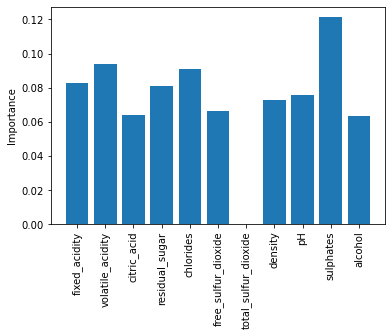

In [43]:
plt.bar(X.columns, gs_best.feature_importances_)
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

**Features (explanatory variable) with the largest importance: alcohol**  
**重要度が最大の説明変数(特徴量): alcohol**  

#### Save the best predictor  

In [44]:
tag = 'ai-12-assign1'
model_file = 'abr_best_{}.joblib'.format(tag)
dump(gs_best, model_file)

['abr_best_ai-12-assign1.joblib']